## Logistic Regression on Iris dataset
In this notebook, I will demonstrate classification employing logistic regression on the Iris dataset. 
Iris has four features and three labels (species). Here, the classifier works on two selected features.<br>
To classify, we need a classifier, which divides the input space into a collection of regions belonging to each class. The boundaries of these regions are called decision boundaries. We construct a predictor based on the training set and are interested in applying the predictor to new data.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm

from jupyterthemes import jtplot
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=True, figsize=(15, 10))

import sklearn.datasets as datasets

X, y = datasets.load_iris(return_X_y=True)
y = y
X = X[:, [1, 3]] # sepal length and petal width
print("Iris data size is {}".format(X.shape))
print("Iris target size is {}".format(y.shape))
print("The first five samples of Iris {}".format(X[:5]))

Iris data size is (150, 2)
Iris target size is (150,)
The first five samples of Iris [[3.5 0.2]
 [3.  0.2]
 [3.2 0.2]
 [3.1 0.2]
 [3.6 0.2]]


#### We have to download and prepare Iris dataset. Function batch_iter is for Gradient Descent. 

In [73]:
def split_data(x, y, ratio, myseed=1):
    """split the dataset based on the split ratio."""
    # set seed
    #np.random.seed(myseed)
    # generate random indices
    num_row = len(y)
    indices = np.random.permutation(num_row)
    #indices = range(0, len(y))
    index_split = int(np.floor(ratio * num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    # create split
    x_tr = x[index_tr]
    x_te = x[index_te]
    y_tr = y[index_tr]
    y_te = y[index_te]
    return x_tr, x_te, y_tr, y_te

def standardise(x):
    """Standardise the original data set."""
    mean_x = np.mean(x, axis=0)
    x = x - mean_x
    std_x = np.std(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x

def init_params(weights_shape, bias_shape=(1,), dtype='float64',
                 scale=0.01, random_seed=None):
    """Initialize weight coefficients."""
    if random_seed:
        np.random.seed(random_seed)
    w = np.random.normal(loc=0.0, scale=scale, size=weights_shape)
    b = np.zeros(shape=bias_shape)
    return b.astype(dtype), w.astype(dtype)

def one_hot(y, n_labels, dtype):
    """Performs one-hot encoding"""
    mat = np.zeros((len(y), n_labels))
    for i, val in enumerate(y):
        mat[i, val] = 1
    return mat.astype(dtype) 

def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """To apply stochastic GD"""
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]


#### There are functions of clasiffier below

In [74]:
# For each iteration
def net_input(X, W, b):
    """Farward pass"""
    return (X.dot(W) + b)

def softmax(z):
    """Sigmoid function"""
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

def get_grad_soft(soft_out, tx, y):
    """Error and gradient for each pass"""
    err = soft_out - y
    grad = np.dot(tx.T, err)
    return grad, err


# For epoch
def cost(cross_entropy):
    """Cost for entire epoch"""
    cross_entropy = cross_entropy + l2 * np.sum(w ** 2)
    return 0.5 * np.mean(cross_entropy)

def to_classlabels(z):
    """To get labels for classified"""
    return z.argmax(axis=1)

def predict_proba(X):
    """Get probability"""
    net = net_input(X, w, b)
    soft_out = softmax(net)
    return soft_out

def predict(X):
    """Assign labels"""
    probas = predict_proba(X)
    return to_classlabels(probas)


def fit(X, y):
    """Fits parameters of classifier - training"""
    if init_params:
        n_classes = np.max(y) + 1 #need to add one class extra
        n_features = X.shape[1] # number of features

        b, w = init_params(
            weights_shape=(n_features, n_classes),
            bias_shape=(n_classes,),
            random_seed=random_seed)
    costs = []

    y_enc = one_hot(y=y, n_labels=n_classes, dtype=float)
    
    for i in range(epochs):
        for y_batch, x_batch in batch_iter(y_enc, X, batch_size=batch_size, num_batches=num_batches, shuffle=True):
            # givens:
            # w_ -> n_feat x n_classes
            # b_  -> n_classes
            
            # net_input, softmax and diff -> n_samples x n_classes:
            net = net_input(x_batch, w, b)
            soft_out = softmax(net)

            # gradient -> n_features x n_classes
            grad, err = get_grad_soft(soft_out, x_batch, y_batch)
            # update in opp. direction of the cost gradient
            w -= (gamma * grad + gamma * l2 * w)
            b -= (gamma * np.sum(err, axis=0))

        # compute cost of the whole epoch
        net = net_input(x_batch, w, b)
        soft_out = softmax(net)
        output=soft_out
        y_target=y_batch
        cross_ent = - np.sum(np.log(output) * (y_target) + np.log(1.-output) * (1.-y_target), axis=1)
        cross_ent_pen = cross_ent + l2 * np.sum(w ** 2)
        cost = 0.5 * np.mean(cross_ent_pen)
        costs.append(cost)
    return w, b, costs                

#### Let's execute and plot the results.

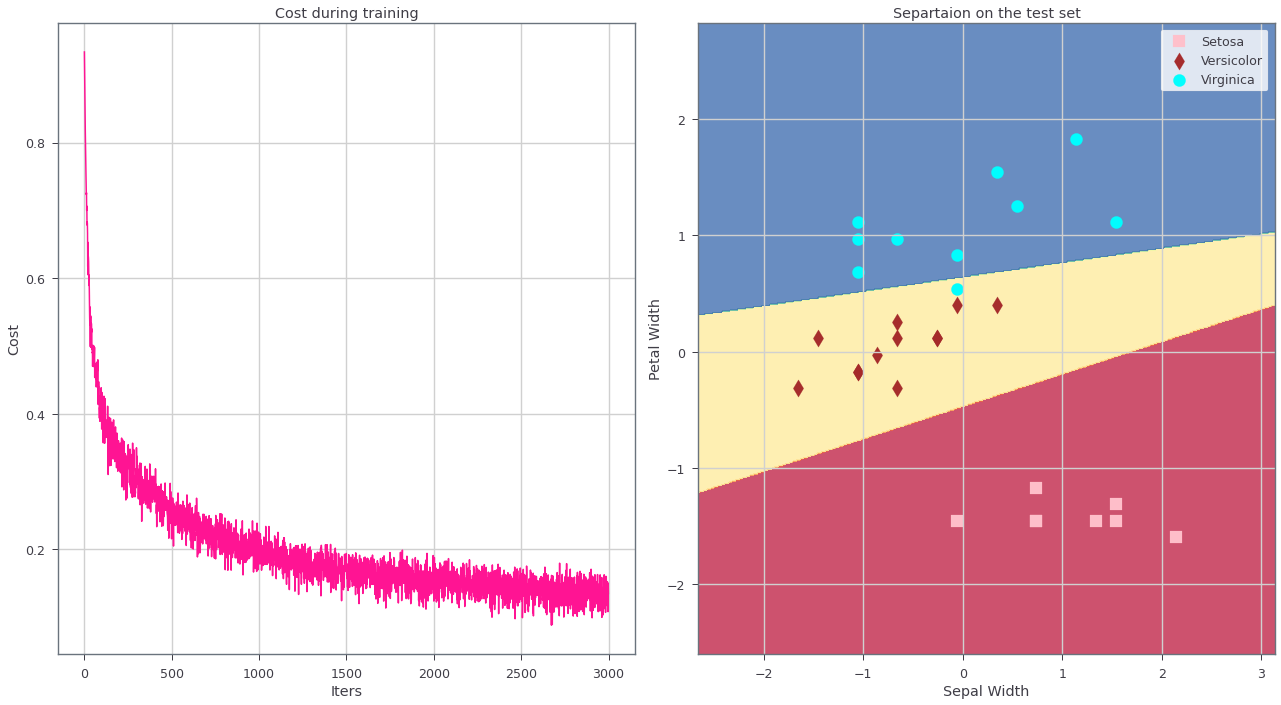

In [75]:
gamma = 0.001
l2 = 0.0001
epochs = 3000
num_batches = 1
batch_size =  80
n_classes = None
shuffle = True
random_seed = np.random.seed(None)

x_tr, x_te, y_tr, y_te = split_data(X, y, 0.8)

x_tr, mean_x_tr, std_x_tr = standardise(x_tr)
x_te, _, _ = standardise(x_te)

w, b, costs = fit(x_tr, y_tr)

def plot_decision_regions_sk(X, y,  resolution=0.01):
    # setup marker generator and color map
    my_cmap = cm.get_cmap('Spectral')
    markers = ('s', 'd', 'o', '^', 'v')
    colors = ('pink', 'brown', 'cyan', 'gray', 'green')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = np.array([xx1.flatten(), xx2.flatten()]).T
    Z = predict(tensor)
    Z = Z.reshape(xx1.shape)#predicted class labal must have the same 
    
    fig = plt.figure(figsize=(18, 10))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(costs, c='deeppink')
    ax1.set_xlabel('Iters')
    ax1.set_ylabel('Cost')
    ax1.set_title('Cost during training')
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.contourf(xx1, xx2, Z, alpha=0.8, cmap=my_cmap)
        # plot class samples
    labels = ['Setosa', 'Versicolor', 'Virginica']
    
    for idx, cl in enumerate(np.unique(y)):
        ax2.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.99, color=cmap(idx),
                    marker=markers[idx], s=150,
                    label=labels[cl])
    ax2.legend()
    ax2.set_xlabel('Sepal Width')
    ax2.set_ylabel('Petal Width')
    ax2.set_title('Separtaion on the test set')
    plt.tight_layout()
    
plot_decision_regions_sk(x_te, y_te)

The logistic model uses a nonlinear activation function but is linear in the parameters. Hence, decision boundaries are straight boundaries. As a result, the separation is not always ideal. 